In [1]:
from pathlib import Path
from glob import glob
import pandas as pd
import numpy as np

from alternationprober.constants import (
    PATH_TO_RESULTS_DIRECTORY,
)

import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
def sorting_key(layer_path):
    """Sort the result paths by the final directory, where ``static`` corresponds to layer 0."""
    if layer_path.stem == "static":
        key = 0
    else:
        key = int(layer_path.stem)
    return key

all_df = pd.DataFrame()

models = ['bert-base-uncased', 'roberta-base', 'google/electra-base-discriminator', 'microsoft/deberta-base']
for model in models:
    if '/' in model:
        model = model.split('/')[1]
    
    experiment_results = PATH_TO_RESULTS_DIRECTORY / "linear-probe-for-word-embeddings" / model
    layer_paths = experiment_results.glob("*/")
    layer_paths = sorted([path for path in layer_paths if path.is_dir()], key=sorting_key)
    for layer in layer_paths:
        layer_df_paths = layer.glob('*/')
        for df_path in layer_df_paths:
            if 'evaluation' in str(df_path):
                df = pd.read_csv(df_path)
                df['layer'] = int(layer.name)
                df['model'] = model
                all_df = all_df.append(df)

# static_results = PATH_TO_RESULTS_DIRECTORY / "linear-probe-for-word-embeddings" / "static"
# for df_path in static_results.glob('*/'):
#     if 'evaluation' in str(df_path):
#         df = pd.read_csv(df_path)
#         df['layer'] = 0
#         df['model'] = ""
#         all_df = all_df.append(df)

In [29]:
frames = ['inchoative', 'causative', 'preposition', '2object', 
    'with', 'locative', 'No-There', 'There', 'Refl', 'Non-Refl']

In [30]:
# Reference MRRs from the CoLA MLP Model
ref_mcc = [0.555, 0, 0.32, 0.482, 0.645, 0.253, 0.459, 0, 0, 0.219]
ref = {frame:mcc for frame, mcc in zip(frames, ref_mcc)}

In [39]:
best_row['layer']

7

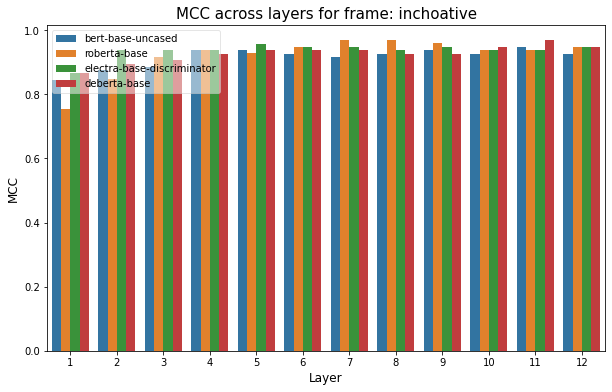

Best Model: roberta-base (7) MCC: 0.9691908869205692


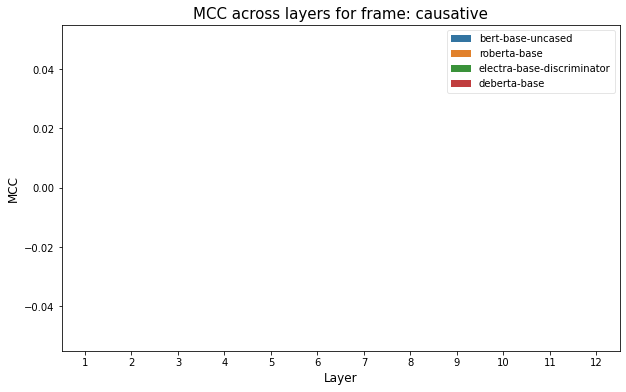

Best Model: bert-base-uncased (1) MCC: 0.0


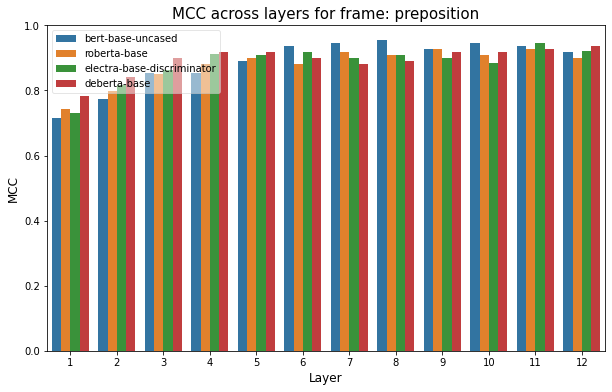

Best Model: bert-base-uncased (8) MCC: 0.9543923215699578


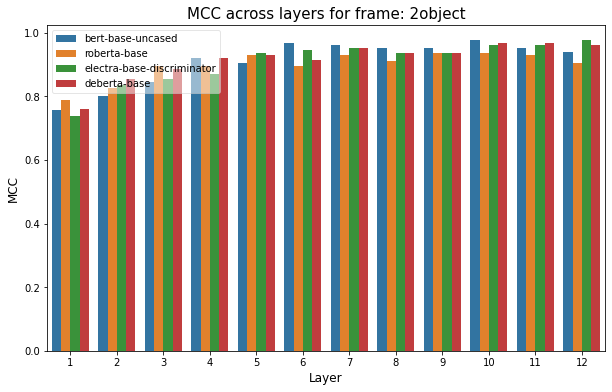

Best Model: bert-base-uncased (10) MCC: 0.9762126783855204


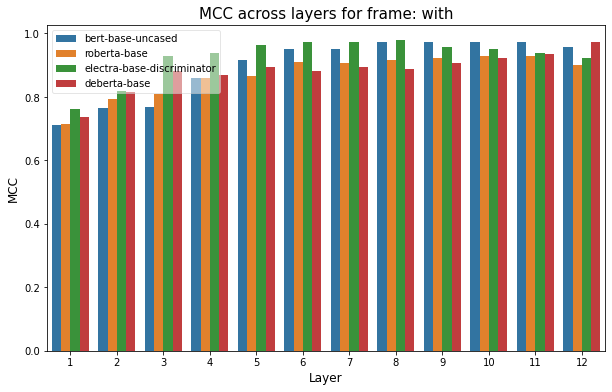

Best Model: electra-base-discriminator (8) MCC: 0.9789135136640332


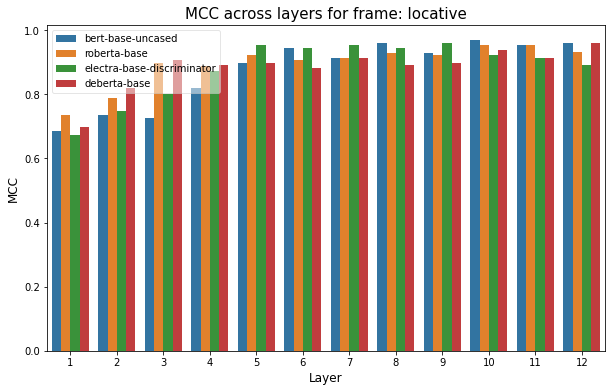

Best Model: bert-base-uncased (10) MCC: 0.9688385768788806


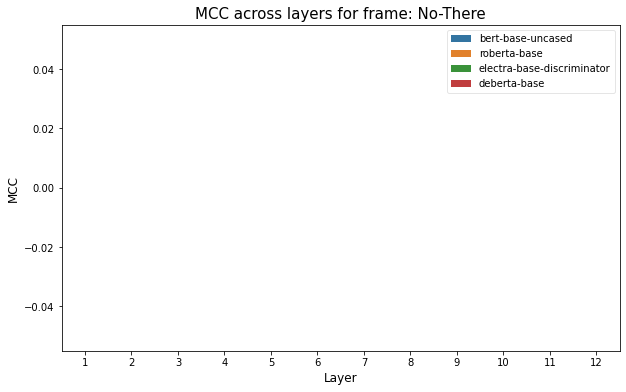

Best Model: bert-base-uncased (1) MCC: 0.0


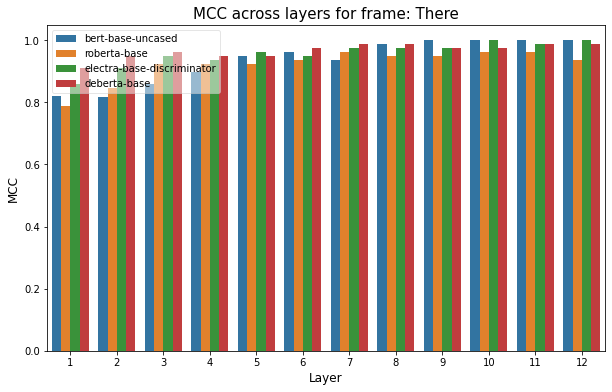

Best Model: bert-base-uncased (9) MCC: 1.0


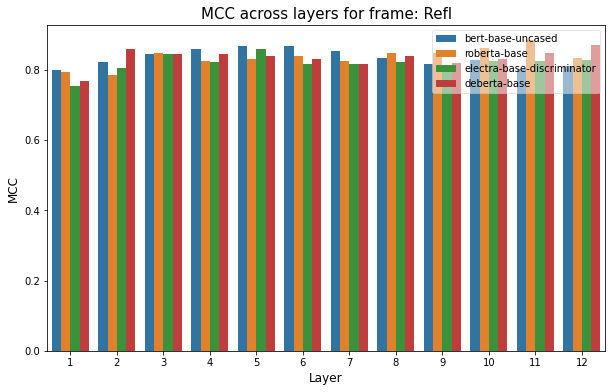

Best Model: roberta-base (11) MCC: 0.8838254133793159


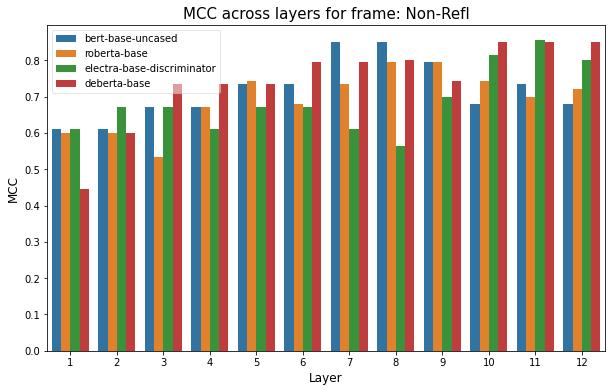

Best Model: electra-base-discriminator (11) MCC: 0.8551815642752498


In [41]:
best_layers = []
best_mccs = []
best_models = []
best_accs = []

for alternation in frames:
    alternation_df = all_df[all_df['alternation_class'] == alternation].reset_index()
    
    # Store variables to create summary df
    best_row = alternation_df[alternation_df['mcc'] == alternation_df['mcc'].max()].iloc[0]

    best_layer = best_row['layer']
    best_mcc = best_row['mcc']
    best_acc = best_row['accuracy']
    best_model = best_row['model']

    best_layers.append(best_layer)
    best_mccs.append(best_mcc)
    best_models.append(best_model)
    best_accs.append(best_acc)

    # Create barplot
    plt.figure(figsize=(10, 6))
    fig = sns.barplot(x=alternation_df['layer'], y=alternation_df['mcc'], hue=alternation_df['model'])

    plt.title(f'MCC across layers for frame: {alternation}', fontsize=15)
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('MCC', fontsize=12)
    plt.legend(framealpha=0.5)
    plt.show()
    print(f'Best Model: {best_model} ({best_layer}) MCC: {best_mcc}')

In [42]:
# # Heatmap of layer performance
# layer_mccs = np.array(all_df.groupby('layer')[['mcc']].agg(list).reset_index()['mcc'].values.tolist())
# plt.figure(figsize=(8, 6))
# heatmap = sns.heatmap(layer_mccs, xticklabels=all_df['alternation_class'].unique())
# plt.xlabel('Frame')
# plt.ylabel('Layer')
# plt.xticks(rotation=45)
# heatmap;

In [47]:
best_layer_df = all_df.groupby(['model', 'alternation_class'])[['mcc', 'accuracy']].max().reset_index()
best_layer_df = pd.merge(best_layer_df, all_df, how='left', on=['model', 'alternation_class', 'mcc', 'accuracy'])[
    ['model', 'layer', 'alternation_class', 'mcc', 'accuracy']
]

best_layer_df.drop_duplicates(['model', 'alternation_class'])

,model,layer,alternation_class,mcc,accuracy
0,bert-base-uncased,10,2object,0.976213,0.994186
1,bert-base-uncased,1,No-There,0.000000,1.000000
13,bert-base-uncased,7,Non-Refl,0.850271,0.994163
15,bert-base-uncased,6,Refl,0.867820,0.964215
16,bert-base-uncased,9,There,1.000000,1.000000
20,bert-base-uncased,1,causative,0.000000,1.000000
32,bert-base-uncased,11,inchoative,0.948268,0.976959
33,bert-base-uncased,10,locative,0.968839,0.988338
34,bert-base-uncased,8,preposition,0.954392,0.988688
35,bert-base-uncased,10,with,0.971998,0.988338


In [56]:
mean_agg = all_df.groupby(['model', 'layer'])[['mcc', 'accuracy']].mean().reset_index()
mean_agg.head()

,model,layer,mcc,accuracy
0,bert-base-uncased,1,0.594349,0.944259
1,bert-base-uncased,2,0.619657,0.952646
2,bert-base-uncased,3,0.645153,0.957916
3,bert-base-uncased,4,0.681829,0.970890
4,bert-base-uncased,5,0.709644,0.978702


Text(0.5, 1.0, 'Mean MCC across Layers')

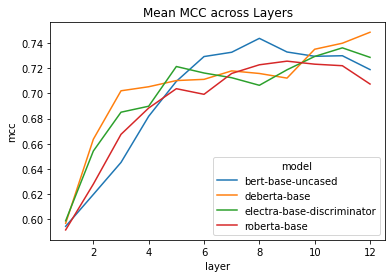

In [54]:
sns.lineplot(x=mean_agg['layer'], y=mean_agg['mcc'], hue=mean_agg['model'])
plt.title('Mean MCC across Layers')

In [55]:
"""
Note: No-there, causative are expected to have 0 MCC since they only have one class
We suspect there is error in the author's evaluation reports, and they switched their metrics for
there/no-there and refl/non-refl
"""

pd.DataFrame(data={
    'Frame': frames,
    'Best Model': best_models,
    'layer': best_layers,
    'Layer MCC': best_mccs,
    'Accuracy': best_accs
    }
)

,Frame,Best Model,layer,Layer MCC,Accuracy
0,inchoative,roberta-base,7,0.969191,0.986175
1,causative,bert-base-uncased,1,0.000000,1.000000
2,preposition,bert-base-uncased,8,0.954392,0.988688
3,2object,bert-base-uncased,10,0.976213,0.994186
4,with,electra-base-discriminator,8,0.978914,0.991254
5,locative,bert-base-uncased,10,0.968839,0.988338
6,No-There,bert-base-uncased,1,0.000000,1.000000
7,There,bert-base-uncased,9,1.000000,1.000000
8,Refl,roberta-base,11,0.883825,0.968191
9,Non-Refl,electra-base-discriminator,11,0.855182,0.994163
